# Import libraries and load data

In [1]:
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers.experimental.preprocessing import Resizing
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers, applications
from tensorflow.keras.applications import vgg19
import tensorflow as tf
from keras.models import load_model

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import json

In [2]:
insta_meta = pd.read_csv('recipes.csv', sep=';')
columns_tag = [i for i in insta_meta.columns if 'tag' in i]
insta_meta_tags = insta_meta[columns_tag + ["photo_id"]]

# EDA

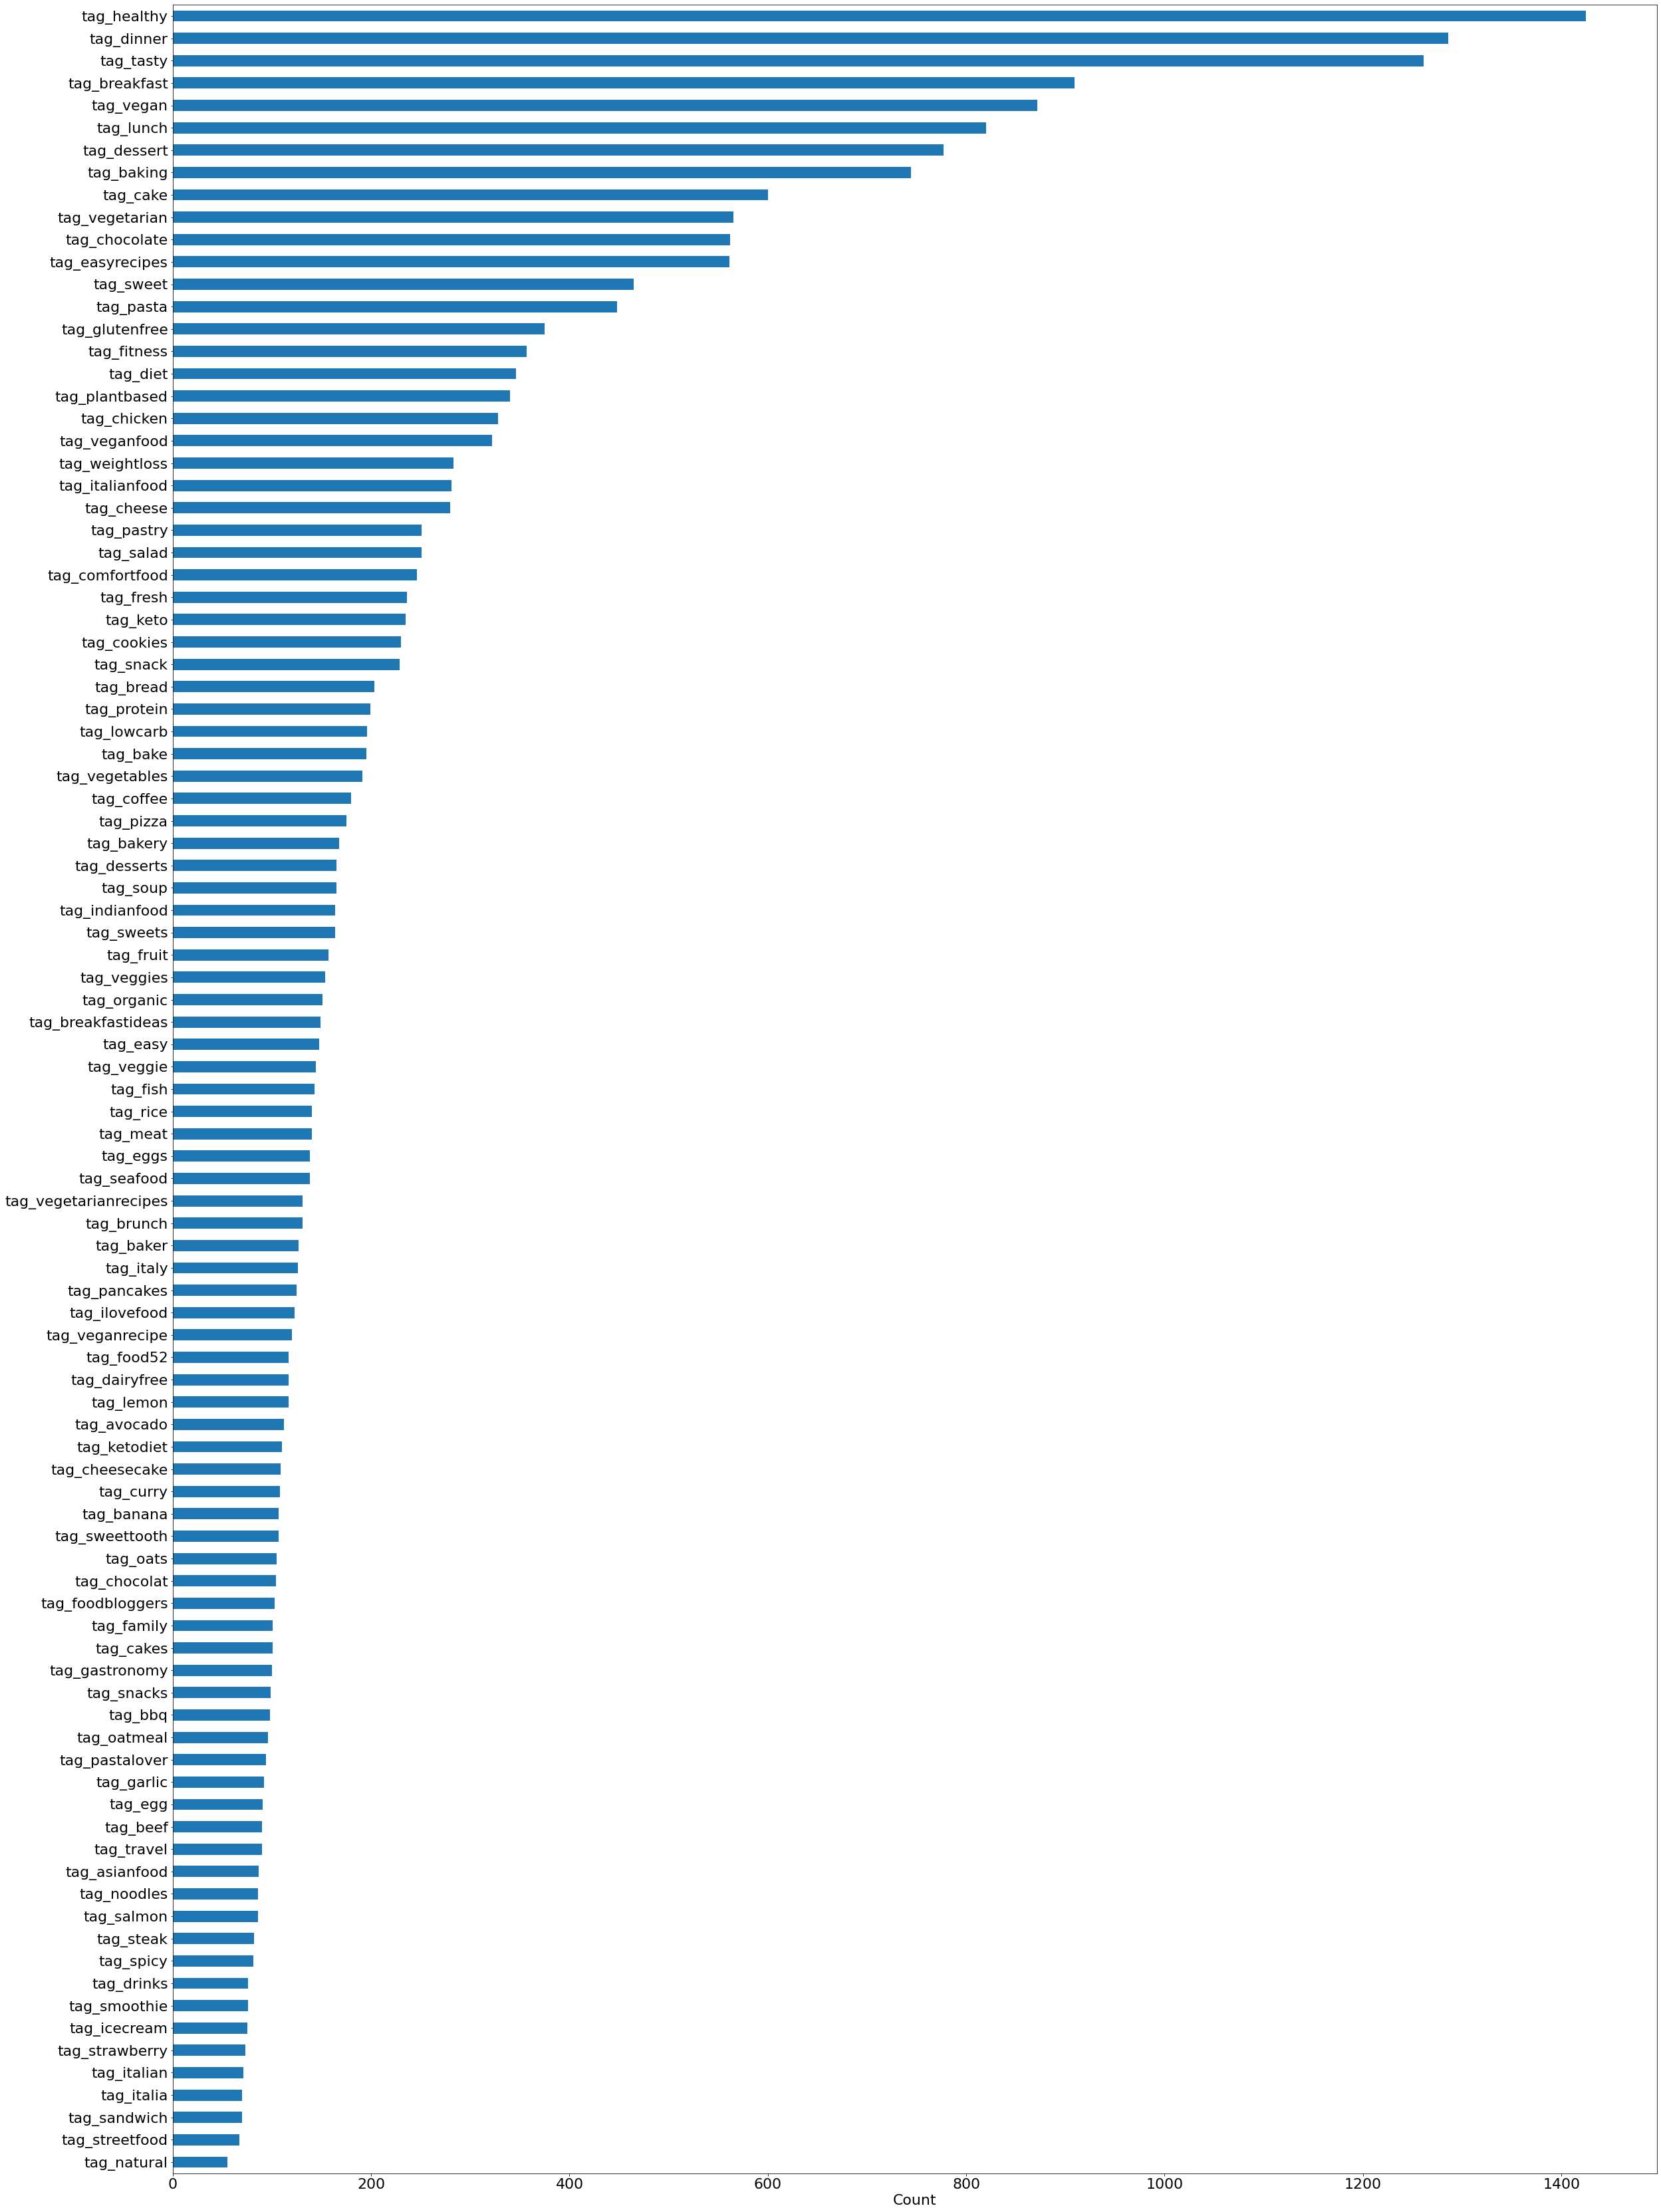

In [3]:
fig = plt.figure(figsize=(40,60))
insta_meta_tags.drop(columns=["photo_id"]).sum().sort_values().plot(kind="barh", fontsize=22)
plt.xlabel('Count', fontsize=22)
plt.savefig('./images/tag_distribution.png')

In [3]:
# look at amount of hashtags (-1 for id variable)
len(insta_meta_tags.columns) - 1

97

# Data prep

In [4]:
# add '.png' to photo_id for loading later on
insta_meta_tags.loc[:,'photo_id'] = insta_meta_tags.loc[:,"photo_id"] + '.png'

C:\Users\u0143591\Anaconda3\envs\keras\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [137]:
# set top 3 of hashtags in terms of observations collected
top_3 = list(insta_meta_tags.iloc[:,:-1].sum()\
             .sort_values(ascending=False)[:3].index)

In [5]:
# select tags of interest
TOI = ["tag_chicken", "tag_pasta", "tag_chocolate"]

### 1/ Create subsample of data for trial

In [5]:
train = insta_meta_tags[top_3 + ["photo_id"]].sample(frac=0.10, random_state=42)

In [6]:
test = insta_meta_tags.drop(train.index)[top_3 + ["photo_id"]].sample(frac=0.03, random_state=42)

In [7]:
validate = insta_meta_tags.drop(list(train.index) + list(test.index))[top_3 + ["photo_id"]].sample(frac=0.03, random_state=42)

### 2/ Create train test validate for all data

In [6]:
train, validate, test = np.split(insta_meta_tags[TOI + ["photo_id"]].sample(frac=1, random_state=42), 
                                 [int(.7*len(insta_meta_tags)), int(.9*len(insta_meta_tags))])

### 3/ Create data generator objects

In [8]:
# for #chocolate
df = insta_meta_tags.copy()

datagen=ImageDataGenerator(rotation_range=10,
                           zoom_range=0.2,
                           horizontal_flip=True)

test_datagen=ImageDataGenerator()

train_generator=datagen.flow_from_dataframe(dataframe=train,
                                            directory="./recipes",
                                            x_col="photo_id",
                                            y_col="tag_chocolate",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(224,224))

valid_generator=test_datagen.flow_from_dataframe(dataframe=validate,
                                                 directory="./recipes",
                                                 x_col="photo_id",
                                                 y_col="tag_chocolate",
                                                 batch_size=32,
                                                 seed=42,
                                                 shuffle=True,
                                                 class_mode="raw",
                                                 target_size=(224,224))

test_generator=test_datagen.flow_from_dataframe(dataframe=test,
                                                directory="./recipes",
                                                x_col="photo_id",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None)

Found 8187 validated image filenames.
Found 2339 validated image filenames.
Found 1170 validated image filenames.


In [61]:
# for tags of interest
df = insta_meta_tags.copy()

datagen=ImageDataGenerator(rotation_range=10,
                           zoom_range=0.2,
                           horizontal_flip=True)

test_datagen=ImageDataGenerator()

train_generator=datagen.flow_from_dataframe(dataframe=train, 
                                            directory="./recipes",
                                            x_col="photo_id",
                                            y_col=TOI,
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(224,224))

valid_generator=test_datagen.flow_from_dataframe(dataframe=validate, 
                                                 directory="./recipes",
                                                 x_col="photo_id",
                                                 y_col=TOI,
                                                 batch_size=32,
                                                 seed=42,
                                                 shuffle=True,
                                                 class_mode="raw",
                                                 target_size=(224,224))

test_generator=test_datagen.flow_from_dataframe(dataframe=test,
                                                directory="./recipes",
                                                x_col="photo_id",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None)

Found 8187 validated image filenames.
Found 2339 validated image filenames.
Found 1170 validated image filenames.


In [62]:
# define generator wrapper to be used later on in fit-call
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x, [batch_y[:,i] for i in range(len(TOI))])

# Modelling
## VGG19

### for single output

In [379]:
inp = Input(shape = (224,224,3))
x = tf.cast(inp, tf.float32)
x = vgg19.preprocess_input(x) # preprocessing specific for VGG19
# load VGG19 base
vgg_base = applications.VGG19(include_top=False, weights='imagenet', input_tensor=x)
vgg_base.trainable = False # freeze the trainable layers of VGG19
# we provide our inputs to the base_model
x = vgg_base(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(1, activation="sigmoid")(x)
model_vgg_1 = Model(vgg_base.input, output)
model_vgg_1.compile(optimizers.Adam(learning_rate = 0.0001),
              loss="binary_crossentropy",
              metrics = ["AUC", 'TruePositives'])

### for 3-label output

In [207]:
inp = Input(shape = (224,224,3))
x = tf.cast(inp, tf.float32)
x = preprocess_input(x)
# VGG19
vgg_base = applications.VGG19(include_top=False, weights='imagenet', input_tensor=x)
vgg_base.trainable = False # freeze the trainable layers of VGG19
# unfreeze last 2 blocks of VGG19 to fine-tune, NOT DESIRABLE IF LOW AMOUNT OF DATA
for layer in vgg_base.layers[:12]:
   layer.trainable = False
for layer in model.layers[12:]:
   layer.trainable = True
# we provide our inputs to the base_model
x = vgg_base(x)
#x = Conv2D(1024, (2,2), activation='relu', padding='same')(x)
#x = Conv2D(512, (2,2), activation='relu', padding='same')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
outputs = [Dense(1, activation = 'sigmoid')(x) for i in range(len(top_3))]
model = Model(vgg_base.input, outputs)
# load weights from previous training round if desired
#model.load_weights("keras_trial_modelv8_vgg_3classes.h5")

# compile model
model.compile(optimizers.Adam(learning_rate = 0.001, decay = 1e-06),
              loss = ["binary_crossentropy" for i in range(len(top_3))],
              metrics = ["accuracy", 'TruePositives'])

In [380]:
model.summary()

Model: "functional_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_39  (None, 512)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 257       
Total params: 20,155,969
Trainable params: 131,585
Non-trainable params: 20,024,384
___________________________________

## ResNet 50

In [10]:
# specific preprocess import for ResNet50
from tensorflow.keras.applications.resnet_v2 import preprocess_input

### for single output - no dropout

In [29]:
inp = Input(shape = (224,224,3), name="Input")
x = tf.cast(inp, tf.float32)
x = preprocess_input(x)
# ResNet-50
resn_base = applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
resn_base.trainable = False # freeze the trainable layers of the ResNet-50
# we provide our inputs to the base_model
x = resn_base(x)
#x = Conv2D(1024, (2,2), activation='relu', padding='same')(x)
#x = Conv2D(512, (2,2), activation='relu', padding='same')(x)
x = GlobalAveragePooling2D(name="global_average_pooling2d")(x)
#x = Flatten()(x)
x = Dense(1024, activation='relu', name='hidden_layer_ReLu')(x)
outputs = Dense(1, activation = 'sigmoid', name='Dense_13')(x)
resn_single_outpt = Model(inp, outputs)
# compile model
resn_single_outpt.compile(optimizers.Adam(learning_rate = 0.0001),
                          loss = "binary_crossentropy",
                          metrics = ["AUC", 'TruePositives'])

In [54]:
resn_single_outpt.summary()

Model: "functional_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_11 (Tens [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_11 (TensorFl [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
hidden_layer_ReLu (Dense)    (None, 1024)              2098176   
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

### for single output - dropout on every layer (also input)

In [46]:
inp = Input(shape = (224,224,3), name="Input")
x = tf.cast(inp, tf.float32)
x = preprocess_input(x)
x = Dropout(0.4, name='dropout_0.4_1')(x)
# ResNet-50
resn_base = applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
resn_base.trainable = False # freeze the trainable layers of the ResNet-50
# we provide our inputs to the base_model
x = resn_base(x)
#x = Conv2D(1024, (2,2), activation='relu', padding='same')(x)
#x = Conv2D(512, (2,2), activation='relu', padding='same')(x)
x = GlobalAveragePooling2D(name="global_average_pooling2d")(x)
x = Dropout(0.2, name='dropout_0.2_2')(x)
x = Dense(1024, activation='relu', name='hidden_layer_ReLu')(x)
#x = Dropout(0.2, name='dropout_0.5_3')(x)
outputs = Dense(1, activation = 'sigmoid', name='Dense_13')(x)
resn_single_outpt_dropt = Model(inp, outputs)
# compile model
resn_single_outpt_dropt.compile(optimizers.Adam(learning_rate = 0.001),
                          loss = "binary_crossentropy",
                          metrics = ["AUC", 'TruePositives'])

In [41]:
resn_single_outpt_dropt.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
dropout_0.2_1 (Dropout)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_0.2_2 (Dropout)      (None, 2048)             

### for 3-label output

In [52]:
inp = Input(shape = (224,224,3), name="Input")
x = tf.cast(inp, tf.float32)
x = preprocess_input(x)
x = Dropout(0.3, name='dropout_0.3_1')(x)
# ResNet-50
resn_base = applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
resn_base.trainable = False # freeze the trainable layers of the ResNet-50
# we provide our inputs to the base_model
x = resn_base(x)
#x = Conv2D(1024, (2,2), activation='relu', padding='same')(x)
#x = Conv2D(512, (2,2), activation='relu', padding='same')(x)
x = GlobalAveragePooling2D(name="global_average_pooling2d")(x)
x = Dropout(0.2, name='dropout_0.2_2')(x)
x = Dense(1024, activation='relu', name='hidden_layer_ReLu')(x)
#x = Dropout(0.2, name='dropout_0.5_3')(x)
outputs = [Dense(1, activation = 'sigmoid', name=f"Out_{i}")(x) for i in range(len(TOI))]
resn_3tag_outpt_dropt = Model(inp, outputs)
# compile model
resn_3tag_outpt_dropt.compile(optimizers.Adam(learning_rate = 0.001),
                          loss =  ["binary_crossentropy" for i in range(len(TOI))],
                          metrics = ["AUC", 'TruePositives'])

In [53]:
resn_3tag_outpt_dropt.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_4 (TensorFl [(None, 224, 224, 3) 0           Input[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_Sub_4 (TensorFlowOp [(None, 224, 224, 3) 0           tf_op_layer_RealDiv_4[0][0]      
__________________________________________________________________________________________________
dropout_0.3_1 (Dropout)         (None, 224, 224, 3)  0           tf_op_layer_Sub_4[0][0]          
_______________________________________________________________________________________

# Model fitting

### VGG19 no dropout  - single output

In [377]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_choc = model_vgg_1.fit(x=train_generator,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_generator,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=5,verbose=1
                  )

Epoch 1/5
255/255 [==============================] - 994s 4s/step - loss: 0.1895 - auc: 0.8195 - true_positives: 67.0000 - val_loss: 0.2615 - val_auc: 0.6577 - val_true_positives: 6.0000
Epoch 2/5
255/255 [==============================] - 993s 4s/step - loss: 0.1698 - auc: 0.8328 - true_positives: 92.0000 - val_loss: 0.2581 - val_auc: 0.6373 - val_true_positives: 7.0000
Epoch 3/5
255/255 [==============================] - 986s 4s/step - loss: 0.1510 - auc: 0.8620 - true_positives: 101.0000 - val_loss: 0.2556 - val_auc: 0.6491 - val_true_positives: 7.0000
Epoch 4/5
255/255 [==============================] - 989s 4s/step - loss: 0.1402 - auc: 0.8865 - true_positives: 120.0000 - val_loss: 0.2492 - val_auc: 0.6554 - val_true_positives: 7.0000
Epoch 5/5
255/255 [==============================] - 1036s 4s/step - loss: 0.1348 - auc: 0.8831 - true_positives: 126.0000 - val_loss: 0.2680 - val_auc: 0.6523 - val_true_positives: 5.0000


In [ ]:
model_vgg_1.save("keras_trial_model_vgg_chocolate.h5")

### VGG19 dropout 40  - single output

In [ ]:
model_choc = load_model("keras_trial_model_vgg_chocolate.h5")

In [ ]:
x = Dropout(0.4)(model_choc.layers[-2].output)
outputs = Dense(1, activation='sigmoid')(x)
model_vgg_dropout40_1 = Model(inputs=model_choc.input, outputs=outputs)
model_vgg_dropout40_1.compile(optimizers.Adam(learning_rate = 0.001),
                              loss = "binary_crossentropy",
                              metrics = ["AUC", 'TruePositives'])

In [ ]:
model_vgg_dropout40_1.load_weights("keras_trial_model_vgg_chocolate.h5")

In [471]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_choc_40_hist = model_vgg_dropout40_1.fit(x=train_generator,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_generator,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=10,verbose=1
                  )

Epoch 1/10
255/255 [==============================] - 2693s 11s/step - loss: 0.1965 - auc_3: 0.7591 - true_positives_3: 42.0000 - val_loss: 0.2284 - val_auc_3: 0.6477 - val_true_positives_3: 3.0000
Epoch 2/10
255/255 [==============================] - 2669s 10s/step - loss: 0.1849 - auc_3: 0.7707 - true_positives_3: 38.0000 - val_loss: 0.2169 - val_auc_3: 0.6617 - val_true_positives_3: 3.0000
Epoch 3/10
255/255 [==============================] - 2705s 11s/step - loss: 0.1728 - auc_3: 0.7970 - true_positives_3: 44.0000 - val_loss: 0.2108 - val_auc_3: 0.6832 - val_true_positives_3: 3.0000
Epoch 4/10
255/255 [==============================] - 2718s 11s/step - loss: 0.1711 - auc_3: 0.7959 - true_positives_3: 41.0000 - val_loss: 0.2098 - val_auc_3: 0.6962 - val_true_positives_3: 3.0000
Epoch 5/10
255/255 [==============================] - 2702s 11s/step - loss: 0.1587 - auc_3: 0.8140 - true_positives_3: 62.0000 - val_loss: 0.2063 - val_auc_3: 0.6877 - val_true_positives_3: 3.0000
Epoch 6/10

In [ ]:
#model_vgg_dropout40_1.save("keras_trial_vgg_choc_dropout40.h5") # or save as .tf

In [472]:
json = json.dumps(result_choc_40_hist.history)
f = open("result_vgg_dropout40_round2.json","w")
f.write(json)
f.close()

### VGG19 dropout 50  - single output

In [506]:
model_vgg_dropout40_1 = load_model("keras_trial_vgg_choc_dropout40_round2.h5")

In [510]:
x = Dropout(0.5, name="dropout_0.50")(model_vgg_dropout40_1.layers[-3].output) # take first layers up until just before dropout40 
outputs = Dense(1, activation='sigmoid', name="dense_1")(x)
model_vgg_50_1 = Model(inputs=model_vgg_dropout40_1.input, outputs=outputs)
model_vgg_50_1.compile(optimizers.Adam(learning_rate = 0.001),
              loss = "binary_crossentropy",
              metrics = ["AUC", 'TruePositives'])

In [513]:
model_vgg_50_1.summary()

Model: "functional_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_39  (None, 512)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_0.50 (Dropout)       (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 20,155,969
Trainable params: 131,585
Non-trainable params: 20,024,384
__________________________________

need to load weights after compiling to train with same weights as previous round. See [here](https://github.com/tensorflow/tensorflow/issues/36320) at bottom. 

In [512]:
# after changing the structure, we reload the weights from our trained model from previous round
model_vgg_50_1.load_weights("keras_trial_vgg_choc_dropout40_round2.h5")

In [514]:
# model_vgg_50_1 fit
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_choc_50_hist = model_vgg_50_1.fit(x=train_generator,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_generator,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=3,verbose=1
                  )

Epoch 1/3
255/255 [==============================] - 2894s 11s/step - loss: 0.2176 - auc: 0.6900 - true_positives: 8.0000 - val_loss: 0.1843 - val_auc: 0.6974 - val_true_positives: 1.0000
Epoch 2/3
255/255 [==============================] - 2876s 11s/step - loss: 0.1751 - auc: 0.7724 - true_positives: 27.0000 - val_loss: 0.1840 - val_auc: 0.7193 - val_true_positives: 0.0000e+00
Epoch 3/3
255/255 [==============================] - 2903s 11s/step - loss: 0.1773 - auc: 0.7671 - true_positives: 23.0000 - val_loss: 0.1897 - val_auc: 0.7143 - val_true_positives: 1.0000


In [515]:
model_vgg_50_1.save("result_vgg_dropout50_round1.h5")

In [517]:
import json
json = json.dumps(result_choc_50_hist.history)
f = open("result_vgg_dropout50_round1.json","w")
f.write(json)
f.close()

In [484]:
# we look at summary before running
model_vgg_50.summary()

Model: "functional_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_39  (None, 512)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 257       
Total params: 20,155,969
Trainable params: 131,585
Non-trainable params: 20,024,384
___________________________________

In [486]:
# first trial
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_choc_50_hist = model_vgg_50.fit(x=train_generator,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_generator,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=2,verbose=1
                  )

Epoch 1/2
255/255 [==============================] - 2997s 12s/step - loss: 0.2918 - auc: 0.6344 - true_positives: 12.0000 - val_loss: 0.1891 - val_auc: 0.6747 - val_true_positives: 1.0000
Epoch 2/2
255/255 [==============================] - 2689s 11s/step - loss: 0.1908 - auc: 0.7222 - true_positives: 18.0000 - val_loss: 0.2014 - val_auc: 0.6998 - val_true_positives: 0.0000e+00


In [476]:
outputs = [Dense(1, activation='sigmoid')(model_choc_40.layers[-2].output) for i in range(len(TOI))]
model_vgg_3tags = Model(inputs=result_choc_40.input, outputs=outputs)
model_vgg_3tags.compile(optimizers.Adam(learning_rate = 0.0001),
              loss = ["binary_crossentropy" for i in range(len(TOI))],
              metrics = ["AUC", 'TruePositives'])

AttributeError: 'History' object has no attribute 'input'

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_3tags_final = model_vgg_3tags.fit(xgenerator_wrappertor_wrappernerator_wrapper(train_generator),
                   steps_per_epoch=STEP_SIZE_TRAIN,
         generator_wrapper     validation_data=generator_wrapper(valid_generator),
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,verbose=1
                  )

In [436]:
result_choc_40.model.layers[-3].output

<tf.Tensor 'dense_88/Relu:0' shape=(None, 256) dtype=float32>

### VGG19 no dropout - multi label

In [440]:
# we start from overfitted model on one single label
result_choc = load_model("keras_trial_model_vgg_chocolate.h5")

In [453]:
# replace last layer by 3-label output layer
outputs = [Dense(1, activation='sigmoid')(result_choc.layers[-2].output) for i in range(len(TOI))]
model_vgg_3tags = Model(inputs=result_choc.input, outputs=outputs)
model_vgg_3tags.compile(optimizers.Adam(learning_rate = 0.0001),
              loss = ["binary_crossentropy" for i in range(len(TOI))],
              metrics = ["AUC", 'TruePositives'])

In [431]:
model_vgg_3tags.summary()

Model: "functional_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50v2 (Functional)         (None, 7, 7, 2048)   23564800    input_63[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_40 (Gl (None, 2048)         0           resnet50v2[0][0]                 
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 1024)         2098176     global_average_pooling2d_40[0][0]
______________________________________________________________________________________

In [455]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_vgg_3tags_hist = model_vgg_3tags.fit(x=generator_wrapper(train_generator),
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=generator_wrapper(valid_generator),
                   validation_steps=STEP_SIZE_VALID,
                   epochs=7,verbose=1
                  )

Epoch 1/7
255/255 [==============================] - 1006s 4s/step - loss: 0.9290 - dense_94_loss: 0.2376 - dense_95_loss: 0.2975 - dense_96_loss: 0.3939 - dense_94_auc: 0.5380 - dense_94_true_positives: 4.0000 - dense_95_auc_1: 0.5486 - dense_95_true_positives_1: 12.0000 - dense_96_auc_2: 0.5461 - dense_96_true_positives_2: 14.0000 - val_loss: 0.7450 - val_dense_94_loss: 0.2114 - val_dense_95_loss: 0.2495 - val_dense_96_loss: 0.2841 - val_dense_94_auc: 0.5782 - val_dense_94_true_positives: 0.0000e+00 - val_dense_95_auc_1: 0.6147 - val_dense_95_true_positives_1: 10.0000 - val_dense_96_auc_2: 0.6115 - val_dense_96_true_positives_2: 9.0000
Epoch 2/7
255/255 [==============================] - 1014s 4s/step - loss: 0.6199 - dense_94_loss: 0.1696 - dense_95_loss: 0.2036 - dense_96_loss: 0.2466 - dense_94_auc: 0.5925 - dense_94_true_positives: 3.0000 - dense_95_auc_1: 0.6445 - dense_95_true_positives_1: 25.0000 - dense_96_auc_2: 0.6628 - dense_96_true_positives_2: 25.0000 - val_loss: 0.6735 

In [489]:
result_vgg_3tags_hist.model.save("result_vgg_3labels_nodropout.h5")

In [492]:
import json
json = json.dumps(result_vgg_3tags_hist.history)
f = open("result_vgg_3labels_nodropout.json","w")
f.write(json)
f.close()

### VGG19 dropout50 - multi label

#### Starting from single label with dropout50

In [520]:
# we start from VGG dropout 50 single label
vgg_dropout50_single = load_model("result_vgg_dropout50_round1.h5")

In [522]:
outputs = [Dense(1, activation='sigmoid')(vgg_dropout50_single.layers[-2].output) for i in range(len(TOI))]
model_vgg_3tags = Model(inputs=vgg_dropout50_single.input, outputs=outputs)
model_vgg_3tags.compile(optimizers.Adam(learning_rate = 0.0001),
              loss = ["binary_crossentropy" for i in range(len(TOI))],
              metrics = ["AUC", 'TruePositives'])

In [523]:
model_vgg_3tags.load_weights("result_vgg_dropout50_round1.h5", skip_mismatch=True, by_name=True)

In [524]:
model_vgg_3tags.summary()

Model: "functional_102"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_62[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_39 (Gl (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
dense_88 (Dense)                (None, 256)          131328      global_average_pooling2d_39[0][0]
_____________________________________________________________________________________

In [525]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_vgg_3tags_hist_r2 = model_vgg_3tags.fit(x=generator_wrapper(train_generator),
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=generator_wrapper(valid_generator),
                   validation_steps=STEP_SIZE_VALID,
                   epochs=10,verbose=1
                  )

Epoch 1/10
255/255 [==============================] - 2985s 12s/step - loss: 1.4686 - dense_105_loss: 0.3772 - dense_106_loss: 0.4930 - dense_107_loss: 0.5984 - dense_105_auc: 0.4816 - dense_105_true_positives: 16.0000 - dense_106_auc_1: 0.5218 - dense_106_true_positives_1: 42.0000 - dense_107_auc_2: 0.5619 - dense_107_true_positives_2: 24.0000 - val_loss: 0.7735 - val_dense_105_loss: 0.2508 - val_dense_106_loss: 0.2457 - val_dense_107_loss: 0.2770 - val_dense_105_auc: 0.4906 - val_dense_105_true_positives: 0.0000e+00 - val_dense_106_auc_1: 0.5543 - val_dense_106_true_positives_1: 0.0000e+00 - val_dense_107_auc_2: 0.6269 - val_dense_107_true_positives_2: 0.0000e+00
Epoch 2/10
255/255 [==============================] - 3016s 12s/step - loss: 0.8017 - dense_105_loss: 0.2469 - dense_106_loss: 0.2890 - dense_107_loss: 0.2659 - dense_105_auc: 0.4830 - dense_105_true_positives: 3.0000 - dense_106_auc_1: 0.5174 - dense_106_true_positives_1: 21.0000 - dense_107_auc_2: 0.6673 - dense_107_true_p

In [526]:
model_vgg_3tags.save("result_vgg_3labels_dropout50.h5")

In [527]:
import json
json = json.dumps(result_vgg_3tags_hist_r2.history)
f = open("result_vgg_3labels_dropout50.json","w")
f.write(json)
f.close()

#### Starting from multi-label w/o dropout

In [561]:
multi_label_nodropout = load_model("result_vgg_3labels_nodropout.h5")

In [533]:
multi_label_nodropout.layers[-4]

In [562]:
multi_label_nodropout.summary()

Model: "functional_82"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_58[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_37 (Gl (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
dense_84 (Dense)                (None, 256)          131328      global_average_pooling2d_37[0][0]
______________________________________________________________________________________

In [563]:
# replace last layer by 3-label output layer
x = Dropout(0.4, name='dropout_40')(multi_label_nodropout.layers[-5].output)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.3, name='dropout_30')(x)
outputs = [Dense(1, activation='sigmoid')(x) for i in range(len(TOI))]
model_vgg_3tags_dropout40 = Model(inputs=multi_label_nodropout.input, outputs=outputs)
model_vgg_3tags_dropout40.compile(optimizers.Adam(learning_rate = 0.0001),
              loss = ["binary_crossentropy" for i in range(len(TOI))],
              metrics = ["AUC", 'TruePositives'])

In [564]:
model_vgg_3tags_dropout40.summary()

Model: "functional_114"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_58[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_37 (Gl (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 512)          0           global_average_pooling2d_37[0][0]
_____________________________________________________________________________________

In [ ]:
model_vgg_3tags_dropout40.load_weights("result_vgg_3labels_nodropout.h5", skip_mismatch=True, by_name=True)

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_vgg_3tags_hist_r3 = model_vgg_3tags_dropout40.fit(x=generator_wrapper(train_generator),
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=generator_wrapper(valid_generator),
                   validation_steps=STEP_SIZE_VALID,
                   epochs=5,verbose=1
                  )

### ResNet 50 - single label

#### Round 1

In [61]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_resn_single_output = resn_single_outpt.fit(x=train_generator,
                               steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=valid_generator,
                               validation_steps=STEP_SIZE_VALID,
                               epochs=10,verbose=1
                              )

Epoch 1/10
255/255 [==============================] - 707s 3s/step - loss: 0.1854 - auc: 0.7271 - true_positives: 9.0000 - val_loss: 0.1741 - val_auc: 0.7633 - val_true_positives: 7.0000
Epoch 2/10
255/255 [==============================] - 673s 3s/step - loss: 0.1531 - auc: 0.8332 - true_positives: 37.0000 - val_loss: 0.1745 - val_auc: 0.7892 - val_true_positives: 8.0000
Epoch 3/10
255/255 [==============================] - 656s 3s/step - loss: 0.1332 - auc: 0.8861 - true_positives: 53.0000 - val_loss: 0.1715 - val_auc: 0.7620 - val_true_positives: 9.0000
Epoch 4/10
255/255 [==============================] - 654s 3s/step - loss: 0.1174 - auc: 0.9202 - true_positives: 85.0000 - val_loss: 0.1729 - val_auc: 0.7531 - val_true_positives: 6.0000
Epoch 5/10
255/255 [==============================] - 680s 3s/step - loss: 0.1068 - auc: 0.9335 - true_positives: 115.0000 - val_loss: 0.1871 - val_auc: 0.7558 - val_true_positives: 20.0000
Epoch 6/10
255/255 [==============================] - 702s 

In [62]:
resn_single_outpt.save("result_resn50_1label_nodropout.h5")
import json
json = json.dumps(result_resn_single_output.history)
f = open("result_resn50_1label_nodropout.json","w")
f.write(json)
f.close()

#### Round 2

In [23]:
model_resn_1tag_nodropt = load_model("result_resn50_1label_nodropout.h5")

In [38]:
model_resn_1tag_nodropt.summary()

Model: "functional_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_11 (Tens (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_Sub_11 (TensorFl (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
hidden_layer_ReLu (Dense)    (None, 1024)              2098176   
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

In [13]:
# replace last layer by 3-label output layer
x = Dropout(0.5, name='dropout_50')(model_resn_1tag_nodropt.layers[-3].output)
x = Dense(1024, activation='relu', name="hidden_layer_ReLu")(x)
x = Dropout(0.4, name='dropout_40')(x)
outputs = Dense(1, activation='sigmoid')(x)
model_resn_1tag_dropout = Model(inputs=model_resn_1tag_nodropt.input, outputs=outputs)
model_resn_1tag_dropout.compile(optimizers.Adam(learning_rate = 0.0001),
              loss = "binary_crossentropy",
              metrics = ["AUC", 'TruePositives'])

In [50]:
resn_single_outpt_dropt.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_3 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_3 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
dropout_0.4_1 (Dropout)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_0.2_2 (Dropout)      (None, 2048)             

In [58]:
resn_single_outpt_dropt.load_weights("result_resn50_1label_dropout_r2.h5", skip_mismatch=True, by_name=True)

None


In [51]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_resn_1tag_dropout = resn_single_outpt_dropt.fit(x=train_generator,
                               steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=valid_generator,
                               validation_steps=STEP_SIZE_VALID,
                               epochs=5,verbose=1
                              )

Epoch 1/5
255/255 [==============================] - 421s 2s/step - loss: 0.2398 - auc: 0.6255 - true_positives: 1.0000 - val_loss: 0.1750 - val_auc: 0.7306 - val_true_positives: 0.0000e+00
Epoch 2/5
255/255 [==============================] - 415s 2s/step - loss: 0.1829 - auc: 0.7179 - true_positives: 0.0000e+00 - val_loss: 0.1942 - val_auc: 0.6989 - val_true_positives: 0.0000e+00
Epoch 3/5
255/255 [==============================] - 414s 2s/step - loss: 0.1726 - auc: 0.7656 - true_positives: 2.0000 - val_loss: 0.2074 - val_auc: 0.6900 - val_true_positives: 0.0000e+00
Epoch 4/5
255/255 [==============================] - 414s 2s/step - loss: 0.1647 - auc: 0.7970 - true_positives: 5.0000 - val_loss: 0.1840 - val_auc: 0.7294 - val_true_positives: 4.0000
Epoch 5/5
255/255 [==============================] - 413s 2s/step - loss: 0.1607 - auc: 0.8038 - true_positives: 19.0000 - val_loss: 0.1960 - val_auc: 0.6899 - val_true_positives: 0.0000e+00


In [54]:
resn_single_outpt_dropt.save("result_resn50_1label_dropout_r3.h5")
import json
json = json.dumps(result_resn_1tag_dropout.history)
f = open("result_resn50_1label_dropout_r3.json","w")
f.write(json)
f.close()

### ResNet 50 - multi label

In [59]:
resn_3tag_outpt_dropt.load_weights("result_resn50_1label_dropout_r2.h5", skip_mismatch=True, by_name=True)

In [60]:
resn_3tag_outpt_dropt.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_4 (TensorFl [(None, 224, 224, 3) 0           Input[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_Sub_4 (TensorFlowOp [(None, 224, 224, 3) 0           tf_op_layer_RealDiv_4[0][0]      
__________________________________________________________________________________________________
dropout_0.3_1 (Dropout)         (None, 224, 224, 3)  0           tf_op_layer_Sub_4[0][0]          
_______________________________________________________________________________________

In [66]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result_resn_3tag_outpt_dropt = resn_3tag_outpt_dropt.fit(x=generator_wrapper(train_generator),
                               steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=generator_wrapper(valid_generator),
                               validation_steps=STEP_SIZE_VALID,
                               epochs=10,verbose=1
                              )

Epoch 1/10
255/255 [==============================] - 421s 2s/step - loss: 0.5674 - Out_0_loss: 0.1485 - Out_1_loss: 0.1788 - Out_2_loss: 0.2400 - Out_0_auc: 0.5861 - Out_0_true_positives: 0.0000e+00 - Out_1_auc_1: 0.6638 - Out_1_true_positives_1: 5.0000 - Out_2_auc_2: 0.6337 - Out_2_true_positives_2: 3.0000 - val_loss: 0.4772 - val_Out_0_loss: 0.1370 - val_Out_1_loss: 0.1659 - val_Out_2_loss: 0.1744 - val_Out_0_auc: 0.6268 - val_Out_0_true_positives: 0.0000e+00 - val_Out_1_auc_1: 0.7145 - val_Out_1_true_positives_1: 3.0000 - val_Out_2_auc_2: 0.7423 - val_Out_2_true_positives_2: 0.0000e+00
Epoch 2/10
255/255 [==============================] - 430s 2s/step - loss: 0.4429 - Out_0_loss: 0.1219 - Out_1_loss: 0.1430 - Out_2_loss: 0.1781 - Out_0_auc: 0.6791 - Out_0_true_positives: 0.0000e+00 - Out_1_auc_1: 0.7443 - Out_1_true_positives_1: 11.0000 - Out_2_auc_2: 0.7380 - Out_2_true_positives_2: 6.0000 - val_loss: 0.4782 - val_Out_0_loss: 0.1423 - val_Out_1_loss: 0.1652 - val_Out_2_loss: 0.170

In [78]:
resn_3tag_outpt_dropt.save('resn_3tag_dropt_r1.h5')

In [79]:
import json
json = json.dumps(result_resn_3tag_outpt_dropt.history)
f = open("result_resn_3tag_outpt_dropt_r1.json","w")
f.write(json)
f.close()

# Evaluation

Evaluation is mainly performed in other notebook called Eval_model

In [19]:
#pip install tqdm
from tqdm import tqdm # timeline for for-loop

In [64]:
model_test = load_model("result_resn50_1label_dropout_r2.h5")

In [80]:
test_output = []
for i in tqdm(test["photo_id"]):
    try:
        test_image = load_img(f'./recipes/{i}', target_size=(224,224))
    except:
        test_output.append(np.nan)
        continue
    test_input = img_to_array(test_image)
    #test_input = img_to_array(test_image) * (1. / 255)
    #x = tf.cast(test_input, tf.float32)
    #x = preprocess_input(x)
    test_input = np.expand_dims(test_input, axis=0)
    pred = resn_3tag_outpt_dropt.predict(test_input)
    test_output.append(pred)

100%|███████████████████████████████████████████████████████████████████| 1170/1170 [02:50<00:00,  6.88it/s]


In [93]:
chicken = []
pasta = []
chocolate = []
for output in test_output:
    try:
        chicken.append(output[0])
        pasta.append(output[1])
        chocolate.append(output[2])
    except:
        chicken.append(np.nan)
        pasta.append(np.nan)
        chocolate.append(np.nan)

In [99]:
test["chicken_pred"] = chicken
test["pasta_pred"] = pasta
test["choc_pred"] = chocolate

In [74]:
k = test[test["choc_pred_nodropout"] >= 0.5]
k[k['tag_chocolate'] == 1]

,tag_chicken,tag_pasta,tag_chocolate,photo_id,choc_pred_dropout,choc_pred_nodropout
8393,0,0,1,CMbMjMssYbs.png,[[0.0017177165]],[[0.0053002834]]
5031,0,0,1,CMRjiFJJ8TY.png,[[0.1718593]],[[0.096452445]]
1645,0,0,1,CMNm-ajlAd9.png,[[0.008329481]],[[0.00315544]]
10869,0,0,1,CMs4tFeJ9gd.png,[[0.01293242]],[[0.002779156]]
5959,0,0,1,CMQAcr_gYJt.png,[[0.07080698]],[[0.09936249]]
2645,0,0,1,CMNM0-yrk54.png,[[0.24950555]],[[0.030837357]]
5408,0,0,1,CMQT7sypxaj.png,[[0.014493495]],[[0.002950579]]
5567,0,0,1,CMQMg4TJ6h_.png,[[0.027395546]],[[0.20154944]]
4018,0,0,1,CMROcw_Acg-.png,[[0.026833534]],[[0.014144719]]
8162,0,0,1,CMSofQEB5f_.png,[[0.07093331]],[[0.006602615]]


In [101]:
test.to_csv('test_predictions_3labels.csv')